In [1]:
import sys
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from redTools import *
from Kcorrect import *
from gamma_P1 import *

redTools.py:55: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py

<Figure size 1600x350 with 19 Axes>

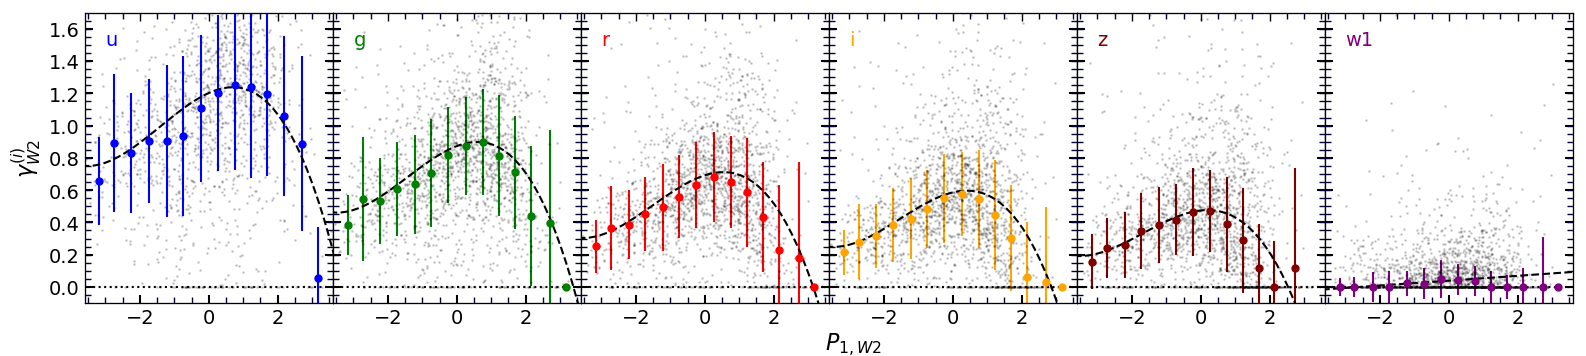

In [2]:
plot_array('ESN_HI_catal.csv', scatter=True, binned=True)

In [55]:
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

pgc = table['pgc']
inc = table['inc']
pc0 = table['pc0']
u0   = table['u']
g0   = table['g']
r0   = table['r']
i0   = table['i']
z0   = table['z']
w1  = table['w1']
w2  = table['w2']
logWimx = table["logWimx"]
m21 = table["m21"]
mu50 = table["mu50"]
Wba = table["Wba"]
R50_w2 = table["R50_w2"]

u = u0-redCorrect(inc, pc0, band1='u', band2='w2')
g = g0-redCorrect(inc, pc0, band1='g', band2='w2')
r = r0-redCorrect(inc, pc0, band1='r', band2='w2')
i = i0-redCorrect(inc, pc0, band1='i', band2='w2')
z = z0-redCorrect(inc, pc0, band1='z', band2='w2')
w1 = w1-redCorrect(inc, pc0, band1='w1', band2='w2')

c21w = m21-w2

In [56]:
def gamma(band1='r', band2='w2'):
    
    r_w1 = table[band1]-table[band2]
    pc0 = table['pc0']
    a,b,c,d, alpha, beta, gamma, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
    q2 = 10**(-1.*gamma)
    F = log_a_b(inc, q2)
    R = r_w1 - (alpha*pc0+beta)
    R[np.where(R<0)]=0
    gama_lambda = R/F
    
    return gama_lambda

In [57]:
gamma_u = gamma(band1='u', band2='w2')
gamma_g = gamma(band1='g', band2='w2')
gamma_r = gamma(band1='r', band2='w2')
gamma_i = gamma(band1='i', band2='w2')
gamma_z = gamma(band1='z', band2='w2')
gamma_w1 = gamma(band1='w1', band2='w2')

indx = np.where(gamma_r>0)
gamma_u=gamma_u[indx]
gamma_g=gamma_g[indx]
gamma_r=gamma_r[indx]
gamma_i=gamma_i[indx]
gamma_z=gamma_z[indx]
gamma_w1=gamma_w1[indx]
pc0=pc0[indx]

indx = np.where(pc0>-3.5)
gamma_u=gamma_u[indx]
gamma_g=gamma_g[indx]
gamma_r=gamma_r[indx]
gamma_i=gamma_i[indx]
gamma_z=gamma_z[indx]
gamma_w1=gamma_w1[indx]
pc0=pc0[indx]

indx = np.where(pc0<2.5)
gamma_u=gamma_u[indx]
gamma_g=gamma_g[indx]
gamma_r=gamma_r[indx]
gamma_i=gamma_i[indx]
gamma_z=gamma_z[indx]
gamma_w1=gamma_w1[indx]
pc0=pc0[indx]

In [58]:
R_ur  = gamma_u/gamma_r
R_gr  = gamma_g/gamma_r
R_ir  = gamma_i/gamma_r
R_zr  = gamma_z/gamma_r
R_w1r = gamma_w1/gamma_r

R_ur  = R_ur[np.where(R_ur>0)]
R_gr  = R_gr[np.where(R_gr>0)]
R_ir  = R_ir[np.where(R_ir>0)]
R_zr  = R_zr[np.where(R_zr>0)]
R_w1r = R_w1r[np.where(R_w1r>0)]

pc0_ur  = pc0[np.where(R_ur>0)]
pc0_gr  = pc0[np.where(R_gr>0)]
pc0_ir  = pc0[np.where(R_ir>0)]
pc0_zr  = pc0[np.where(R_zr>0)]
pc0_w1r = pc0[np.where(R_w1r>0)]

In [59]:
from astropy.stats import sigma_clip
def sigclip(array):
    filtered_data = sigma_clip(array, sigma=2, iters=5, copy=False)
    clipped = filtered_data.data[np.logical_not(filtered_data.mask)]
    return np.median(clipped), clipped, np.logical_not(filtered_data.mask)

In [64]:
C_u, R_ur_, t  =  sigclip(R_ur)
C_g, R_gr_, _  =  sigclip(R_gr)
C_i, R_ir_, _  =  sigclip(R_ir)
C_z, R_zr_, _  =  sigclip(R_zr)
C_w1, R_w1r_, _ =  sigclip(R_w1r)

print C_u, C_g, C_i, C_z, C_w1
pc0_ur_ =  pc0_ur[np.where(t == True)]
print len(pc0_ur_), len(R_ur_)

1.7982118080391154 1.2675455329743022 0.8359592194458687 0.6740501995090331 0.1289045263039968
1336 1336


(0, 5)

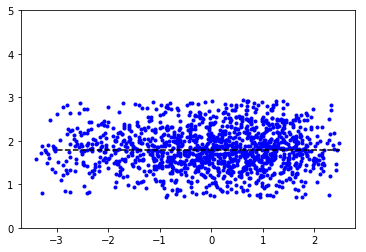

In [65]:
plt.plot(pc0_ur_, R_ur_, 'b.')
plt.plot([-3,2.5],[C_u,C_u],'k--')
plt.ylim(0,5)

(0, 5)

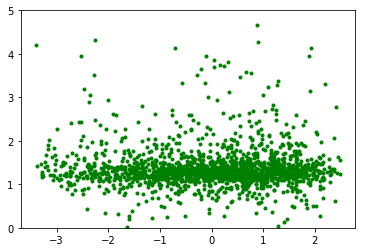

In [38]:
plt.plot(pc0_gr, R_gr, 'g.')
plt.ylim(0,5)

(0, 5)

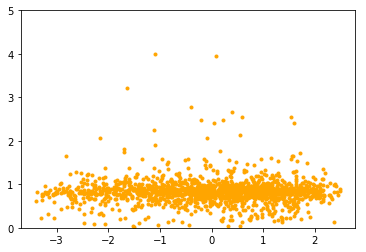

In [41]:
plt.plot(pc0_ir, R_ir, '.', color='orange')
plt.ylim(0,5)

(0, 5)

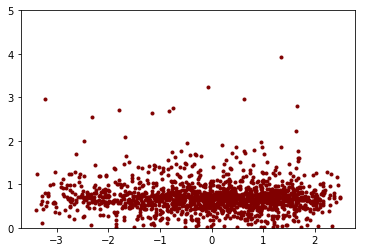

In [40]:
plt.plot(pc0_zr, R_zr, 'g.', color='maroon')
plt.ylim(0,5)